# Question_1

In [2]:
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
from gensim.models import KeyedVectors
from itertools import cycle
from IPython.core.debugger import set_trace
import string
from collections import Counter

In [66]:
#loading the two dataset into two pandas dataframes
data = pd.read_csv('./ds_technical_test_data.csv')
sentiment_words = pd.read_csv('./ds_technical_test_sentiments.csv')

In [4]:
# I downloaded the pre-trained word vectors containing 1 million word vectors trained on Wikipedia 2017
# I will use this for the method calculate_similarity


#n.b due to the huge dimension of the file I won't include it in the github repository
model = KeyedVectors.load_word2vec_format('./wiki-news-300d-1M.vec')

In [67]:
#  I turned the pandas dataframe containing the sentiment words into a dictionary that is a structure
#  more useful in this case

sentiment_words = sentiment_words.set_index('word')['sentiment'].to_dict()


In [68]:
print(nltk.pos_tag(list(sentiment_words.keys())))

[('bad', 'JJ'), ('terrible', 'JJ'), ('fine', 'JJ'), ('awful', 'JJ'), ('great', 'JJ'), ('good', 'JJ'), ('disappointing', 'NN'), ('ok', 'NN')]


In [69]:
sentiment_words

{'awful': -1,
 'bad': -1,
 'disappointing': -1,
 'fine': 1,
 'good': 1,
 'great': 1,
 'ok': 1,
 'terrible': -1}

In [70]:
# Considering that there are many synonyms  like the word nice that will not be considered because it is not contained 
# in the sentiment words I thought it was justified to replace these words with one of those contained in the sentiment_words
# dictionary just if it was a medium-high value of similarity 

def calculate_similarity(word):
    replace_word = word
    if word in model:
        if word not in sentiment_words.keys():
            for k in sentiment_words.keys():
                s = model.similarity(word,k)
                if  s > 0.65:
                    replace_word = k    
    return(replace_word)


In [71]:
# I applied classics pre-processing techniques.
# I did not remove stopwords because, after I will use the technique of chunking to identify different part of the speech
# and to associate the words in the sentiment_Words dictionary to the closest noun.


data['text'] = data['text'].apply(lambda word: word.lower())
data['text'] = data['text'].apply(lambda row: row.translate(str.maketrans('','',string.punctuation)))
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
data['text'] = [[calculate_similarity(word) for word in row] for row in data['text']]


In [72]:
# I wrote the rules to identify the different part of the speech using the nltk library

results = []
idxs = []
for index,row in data.iterrows():
    sentence = nltk.pos_tag(row[0])
    grammar = """key_sentence: {<NN|NNS>+(<.*?>)(<VBG>)} 
                               {(<JJ>|RB)+<NN|NNS>+}
                               {(<NN|NNS>)+(<.*?>)(<JJ>|RB)}
                               {<NNS><VBZ|RB>+<JJ>} 
                               
             """
               
    cp = nltk.RegexpParser(grammar)
    result = cp.parse(sentence)
    if(len(list(result.subtrees())[1:])>0):
#         print(list(result.subtrees())[1:])
        results.append(list(result.subtrees())[1:])
        idxs.append(index)


In [73]:
# method to calculate the minimum distance
def find_min_dist(n,index):
    dist = 100
    word = ''
    for elem in n:
        new_dist = abs(elem[1]-index)
        if new_dist <dist:
            dist=new_dist
            word = elem[0]
    return word
            
#method to calculate the value of the noun    
def calculate_value(x):
    nouns=[]
    value = None
    for i in range(0,len(x)):
        if (x[i][1]) == 'JJ' or (x[i][1]) == 'VBG' :
            try:
                value = sentiment_words.get(x[i][0])
                index = i
            except:
                print('no')
        elif (x[i][1]) == 'NN' or (x[i][1]) == 'NNS':
            nouns.append([x[i][0],i])
    
    if value != None:
        if len(nouns) == 1:
            return [nouns[0][0],value]
        else:
            return [find_min_dist(nouns,index),value]

# method to check if there are any duplicates of nouns
def check_duplicate_values(row_temp):
    if len(row_temp)>1:
        for elem,value in row_temp: 
            if Counter(elem in sl for sl in row_temp)[1] > 1:
                indices = [i for i, row_temp in enumerate(row_temp) if row_temp[0] == elem]
                new_value = sum (row_temp[i][1] for i in indices)
                row_temp = [i for j, i in enumerate(row_temp) if j not in indices]
                row_temp.append([elem,new_value])            
    return row_temp
    
    

In [74]:

outcomes_1 = []
for tree in results:
    row = []
    for sub_tree in tree:
        subt = list(iter(sub_tree))
        word_value = calculate_value(subt)
        if (word_value):
            row.append(word_value)
    outcomes_1.append(check_duplicate_values(row))

    
    
    

In [75]:
final_list = list(zip(outcomes_1,idxs))
final_list = [elem for elem in final_list if len(elem[0])>0]
idxs = [idx for elem,idx in final_list]

In [76]:
ned_data = pd.DataFrame(list(zip([*[elem for elem,index in final_list]])), columns = ['Results'])
ned_data.index = idxs

In [77]:
final_dataset = data.join(ned_data, how='outer')

In [78]:
# for each instance where my regular expressions were able to detect a pattern containing a sentiment word I saved 
# in the column Results the closest noun with the value, NaN otherwise

final_dataset

,text,Results
0,"[this, would, be, a, ok, mouse, if, it, didnt,...","[[mouse, 1]]"
1,"[this, item, it, put, together, well, but, the...",NaN
2,"[i, bought, two, of, these, cards, for, two, d...","[[cards, 1]]"
3,"[this, cable, 16, and, price, tell, you, what,...",NaN
4,"[it, did, not, work, on, my, 2012, tundra, and...",NaN
5,"[never, had, the, experience, to, fully, enjoy...","[[reviews, 1]]"
6,"[item, does, not, workmy, older, lcd, tv, has,...",NaN
7,"[i, bought, this, to, use, with, my, 2011, ima...",NaN
8,"[every, one, i, tried, were, coasters, will, n...",NaN
9,"[they, cant, be, bothered, to, include, good, ...","[[wall, 1]]"


# Question_2

In [79]:
final_dataset['Results'] = final_dataset['Results'].fillna(0)

# I inzialize this column to 1 
final_dataset['Numbers_of_product'] = 1

In [80]:
final_dataset

,text,Results,Numbers_of_product
0,"[this, would, be, a, ok, mouse, if, it, didnt,...","[[mouse, 1]]",1
1,"[this, item, it, put, together, well, but, the...",0,1
2,"[i, bought, two, of, these, cards, for, two, d...","[[cards, 1]]",1
3,"[this, cable, 16, and, price, tell, you, what,...",0,1
4,"[it, did, not, work, on, my, 2012, tundra, and...",0,1
5,"[never, had, the, experience, to, fully, enjoy...","[[reviews, 1]]",1
6,"[item, does, not, workmy, older, lcd, tv, has,...",0,1
7,"[i, bought, this, to, use, with, my, 2011, ima...",0,1
8,"[every, one, i, tried, were, coasters, will, n...",0,1
9,"[they, cant, be, bothered, to, include, good, ...","[[wall, 1]]",1


In [81]:
#to calculate the total points and so the approval rating of a sentence 
#I had just to sum up the points 
#associated to each noun of a sentence.

def calculate_sum(x):
    sum = 0
    for value in enumerate(x):
        sum = sum + value[1][1]
    return(sum)

#in order to calculate the number of products I checked if 
#each noun was singular or plural. If it was plural I assumed 
# that the customer was commenting 2 products.

def number_of_products(x):
    number = 0
    for product in enumerate(x):
        if nltk.pos_tag([product[1][0]])[0][1] == 'NNS':
            number = number + 2
        else:
            number = number + 1 
    return number
        
        

In [82]:
# I used the above method to calculate the overall value of the feedback, summing up all values associated to different nouns
# that belong to the same review

final_dataset['Numbers_of_product'] = final_dataset['Results'].apply(lambda x : 1 if x == 0 else number_of_products(x))
final_dataset['Results'] = final_dataset['Results'].apply(lambda x : 0 if x == 0 else calculate_sum(x))

In [83]:
# I used dummy variables (boolean) to represent all possible combination of value assocaited to one feedback
final_dataset = pd.get_dummies(final_dataset, columns=['Results'])

In [84]:
final_dataset

,text,Numbers_of_product,Results_-1,Results_0,Results_1,Results_2
0,"[this, would, be, a, ok, mouse, if, it, didnt,...",1,0,0,1,0
1,"[this, item, it, put, together, well, but, the...",1,0,1,0,0
2,"[i, bought, two, of, these, cards, for, two, d...",2,0,0,1,0
3,"[this, cable, 16, and, price, tell, you, what,...",1,0,1,0,0
4,"[it, did, not, work, on, my, 2012, tundra, and...",1,0,1,0,0
5,"[never, had, the, experience, to, fully, enjoy...",2,0,0,1,0
6,"[item, does, not, workmy, older, lcd, tv, has,...",1,0,1,0,0
7,"[i, bought, this, to, use, with, my, 2011, ima...",1,0,1,0,0
8,"[every, one, i, tried, were, coasters, will, n...",1,0,1,0,0
9,"[they, cant, be, bothered, to, include, good, ...",1,0,0,1,0


In [58]:
final_dataset = final_dataset.rename( columns={"Results_-1": "Negative", "Results_0": "Null",  "Results_1": "Positive", "Results_2": 'Excellent'})

In [59]:
final_dataset.head()

,text,Numbers_of_product,Negative,Null,Positive,Excellent
0,"[this, would, be, a, ok, mouse, if, it, didnt,...",1,0,0,1,0
1,"[this, item, it, put, together, well, but, the...",1,0,1,0,0
2,"[i, bought, two, of, these, cards, for, two, d...",2,0,0,1,0
3,"[this, cable, 16, and, price, tell, you, what,...",1,0,1,0,0
4,"[it, did, not, work, on, my, 2012, tundra, and...",1,0,1,0,0


In [60]:
#exporting the enriched dataset
final_dataset.to_csv("./Enriched_dataset.csv")

In [61]:
negative  = (final_dataset['Negative'] != 0).sum()
null = (final_dataset['Null'] != 0).sum()
positive = (final_dataset['Positive'] != 0).sum()
excellent = (final_dataset['Excellent'] != 0).sum()

print ("Number of reviews : {} , Negative : {} , Null : {} , Positive : {} , Excellent : {}".format(len(final_dataset),negative,null,positive,excellent))

Number of reviews : 120 , Negative : 4 , Null : 80 , Positive : 30 , Excellent : 6


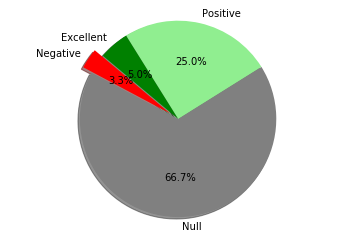

In [63]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Negative', 'Null', 'Positive', 'Excellent'
sizes = [negative,null,positive,excellent]
colors = ['red', 'grey', 'lightgreen', 'green']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()